# P5 Starter - Time Series Analysis 

### Statistical Modeling to Deep Learning

##  Imports & Sanity Check (Do NOT Change)

In [2]:
import numpy as np 
import pandas as pd 
import os
from tqdm.notebook import tqdm
import statsmodels.api as sm # PACF, ACF
from typing import Tuple, List
import plotly.express as px
import plotly.graph_objects as go
# Viz:
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/helper/helper.py
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/oil.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/stores.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/train.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/test.csv
/kaggle/input/cs-639-p-5-spring-25-time-series-forecasting/store-sales-time-series-forecasting/transactions.csv


In [3]:
import importlib.util
import sys

file_path = '/kaggle/input/helper/helper.py'  # full path to the file

spec = importlib.util.spec_from_file_location("helper", file_path)
helper = importlib.util.module_from_spec(spec)
sys.modules["helper"] = helper
spec.loader.exec_module(helper)

## Helper Utilities. Read the Function names at least so that you are not re-writing code

* **make_submission**: Helps you convert your predictions to competition submission ready files.
* **rmsle**: Implementation of the metric used to evaluate your score on the leaderboard.
* **lgbm_rmsle**: Definition that can be used to do train-val type training while printing metric scores.
* **data import**: Imports the necessary files into the notebook
* **preprocess_holidays**: Performs some necessary cleaning on the holiday dataset
* **preprocess_test_train**: Performs some necessary cleaning on the test and train dataset

## Load the data (Do NOT Change)

In [4]:
#########################
# DO NOT CHANGE
#########################
train, test, stores, transactions, oil, holidays = helper.data_import()
holidays, regional, national, local, events, work_day, _, _, _ = helper.preprocess_holidays(holidays)

In [5]:
merged_df = pd.concat([train, test], axis=0)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [6]:
transactions

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83271,2017-08-11,54,768
83325,2017-08-12,54,903
83379,2017-08-13,54,1054
83433,2017-08-14,54,818


## Section 1: EDA & Feature Engineering

### Q1 Left join transaction to train and then print the Spearman Correlation between Total Sales and Transactions.

In [7]:
# TODO - q1
merged_df_q1 = pd.merge(merged_df, transactions, on=['date', 'store_nbr'], how='left')
# print(merged_df.head())
# print(merged_df.columns)

In [8]:
grouped = merged_df_q1.groupby(['date', 'store_nbr']).agg(
    total_sales=('sales', 'sum'),
    avg_transactions=('transactions', 'mean')
).reset_index()

In [9]:
grouped

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,date,store_nbr,total_sales,avg_transactions
0,2013-01-01,1,0.0,NaN
1,2013-01-01,2,0.0,NaN
2,2013-01-01,3,0.0,NaN
3,2013-01-01,4,0.0,NaN
4,2013-01-01,5,0.0,NaN
...,...,...,...,...
90931,2017-08-15,50,0.0,2804.0
90932,2017-08-15,51,0.0,1573.0
90933,2017-08-15,52,0.0,2255.0
90934,2017-08-15,53,0.0,932.0


In [10]:
from scipy.stats import spearmanr

corr, _ = spearmanr(grouped['total_sales'], grouped['avg_transactions'], nan_policy='omit')
print(f"Spearman Correlation between Total Sales and Transactions:",corr)

Spearman Correlation between Total Sales and Transactions: 0.8026966103771125


### ****Q2 Plot an 'ordinary least squares' trendline between transactions and sales to verify the spearman correlation value in Q1. [0.1 Points]

In [52]:
cleaned = grouped.dropna(subset=['total_sales', 'avg_transactions'])

fig = px.scatter(
    cleaned,
    x='avg_transactions',
    y='total_sales',
    trendline='ols',  
    title='OLS Trendline: Total Sales vs Average Transactions',
    labels={
        'avg_transactions': 'Average Transactions',
        'total_sales': 'Total Sales'
    }
)

fig.write_html("/kaggle/working/q2.html")

### Q3 Plot these line charts in the notebook:

A) Transactions vs Date (all stores color coded in the same plot) 

B) Average monthly transactions

 C) Average Transactions on the days of the wee)


In [12]:
# TODO - q3 - Plot A

transactions['date'] = pd.to_datetime(transactions['date'])


fig_q3a = px.line(
    transactions,
    x='date',
    y='transactions',
    color='store_nbr',
    title='Transactions Over Time by Store',
    labels={'transactions': 'Transactions', 'date': 'Date'}
)

fig_q3a.update_xaxes(dtick="M12", tickformat="%Y")

# Save HTML
fig_q3a.write_html("q3a.html")

#fig_q3a.show()


In [13]:
# TODO - q3 - Plot B

transactions['month'] = transactions['date'].dt.month_name()

# Order the months properly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
transactions['month'] = pd.Categorical(transactions['month'], categories=month_order, ordered=True)


monthly_avg = transactions.groupby('month')['transactions'].mean().reset_index()

fig_q3b = px.line(
    monthly_avg,
    x='month',
    y='transactions',
    title='Average Transactions by Month (Across All Years)',
    labels={'month': 'Month', 'transactions': 'Avg Transactions'}
)

fig_q3b.write_html("q3b.html")

/tmp/ipykernel_65/2592133024.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [14]:
# TODO - q3 - Plot C

transactions['day_of_week'] = transactions['date'].dt.day_name()

# Use Categorical ordering for weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transactions['day_of_week'] = pd.Categorical(transactions['day_of_week'], categories=ordered_days, ordered=True)


dow_avg = transactions.groupby('day_of_week')['transactions'].mean().reset_index()

fig_q3c = px.line(
    dow_avg,
    x='day_of_week',
    y='transactions',
    title='Average Transactions by Day of Week',
    labels={'day_of_week': 'Day of Week', 'transactions': 'Avg Transactions'}
)


fig_q3c.write_html("q3c.html")

/tmp/ipykernel_65/921204052.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Q4 Use pandas' in-build (linear) interpolation to impute the missing oil values then overlay the imputed feature over the original.

Your new feature column should be called: `dcoilwtico_interpolated`

In [15]:
# Interpolate 
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico_interpolated'] = oil['dcoilwtico'].interpolate(method='linear')


oil['was_imputed'] = np.where(oil['dcoilwtico'].isna(), True, False)

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=oil['date'],
    y=oil['dcoilwtico'],
    mode='lines',
    name='Original Values',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=oil.loc[oil['was_imputed'], 'date'],
    y=oil.loc[oil['was_imputed'], 'dcoilwtico_interpolated'],
    mode='lines',
    name='Interpolated (Imputed) Values',
    line=dict(color='orange')
))

fig.update_layout(
    title='Oil Prices: Original vs Interpolated (Imputed)',
    xaxis_title='Date',
    yaxis_title='Oil Price (WTI)',
    legend_title='Legend',
    showlegend=True
)

# Save as HTML
fig.write_html("q4.html")

### Q5 Again, left join oil on the dataframe above and report the spearman correlation between oil and sales and oil and transactions

In [16]:
grouped

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,date,store_nbr,total_sales,avg_transactions
0,2013-01-01,1,0.0,NaN
1,2013-01-01,2,0.0,NaN
2,2013-01-01,3,0.0,NaN
3,2013-01-01,4,0.0,NaN
4,2013-01-01,5,0.0,NaN
...,...,...,...,...
90931,2017-08-15,50,0.0,2804.0
90932,2017-08-15,51,0.0,1573.0
90933,2017-08-15,52,0.0,2255.0
90934,2017-08-15,53,0.0,932.0


In [17]:
oil

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,date,dcoilwtico,dcoilwtico_interpolated,was_imputed
0,2013-01-01,NaN,NaN,True
1,2013-01-02,93.14,93.14,False
2,2013-01-03,92.97,92.97,False
3,2013-01-04,93.12,93.12,False
4,2013-01-07,93.20,93.20,False
...,...,...,...,...
1201,2017-08-09,49.59,49.59,False
1202,2017-08-10,48.54,48.54,False
1203,2017-08-11,48.81,48.81,False
1204,2017-08-14,47.59,47.59,False


In [18]:
merged_oil = grouped.merge(oil[['date', 'dcoilwtico_interpolated']], on='date', how='left')
merged_clean_oil = merged_oil.dropna(subset=['dcoilwtico_interpolated'])

corr_sales = merged_clean_oil['total_sales'].corr(merged_clean_oil['dcoilwtico_interpolated'], method='spearman')

corr_transactions = merged_clean_oil['avg_transactions'].corr(merged_clean_oil['dcoilwtico_interpolated'], method='spearman')

print("Correlation Between Oil and Sales:",corr_sales)
print("Correlation Between Oil and Transactions:", corr_transactions)

Correlation Between Oil and Sales: -0.30535288459895554
Correlation Between Oil and Transactions: 0.03796356802652266


### Q6 Report the top-3 highest negative correlations between oil and sales of a particular product family. Now think whether oil should be discarded as a feature?

In [19]:
# Calculate all correlations

train_oil_merged = train.merge(oil[['date', 'dcoilwtico_interpolated']], on='date', how='left')
train_oil_cleaned = train_oil_merged.dropna(subset=['dcoilwtico_interpolated'])

def compute_spearman_corr(df):
    return df['sales'].corr(df['dcoilwtico_interpolated'], method='spearman')

# Report the top 3 
correlations = train_oil_cleaned.groupby('family').apply(compute_spearman_corr)

top3_negative_corr = correlations.nsmallest(3)
print(top3_negative_corr)


family
HOME AND KITCHEN II   -0.652518
HOME AND KITCHEN I    -0.593218
HOME CARE             -0.541245
dtype: float64


/tmp/ipykernel_65/2344277793.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Even though oil doesn’t affect everything, it's still an important factor for some products. That means we should not remove oil prices from the model — in fact, we could even use it differently for different product types.

### Q7. Implement the One hot encode function 

You just have to finish the one-hot encoder function definition for this one.

In [20]:
def one_hot_encoder(df, nan_as_category=True) -> Tuple[pd.DataFrame, List[str]]:
    # One hot encoding (pandas can do it on 1 line!) 
    df = pd.get_dummies(df, dummy_na=nan_as_category)

    # Replace " " with "_" in column names.
    df.columns = df.columns.str.replace(' ', '_')
  
    # Store the new columns in a list
    new_columns = list(df.columns)

    # Return the new dataframe and all the columns (as a list)
    return df, new_columns

In [21]:
#########################
# DO NOT CHANGE. 
# NOTE: Run this after you have implemented the one_hot_encoder function above.
#########################

train, test = helper.preprocess_test_train(merged_df, one_hot_encoder, stores)

## Section 2

In [22]:
train

,id,date,store_nbr,sales,onpromotion,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,...,state_Pastaza,state_Pichincha,state_SantaElena,state_SantoDomingodelosTsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E
0,0.0,2013-01-01,1.0,0.000000,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,2013-01-01,1.0,0.000000,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,2013-01-01,1.0,0.000000,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,2013-01-01,1.0,0.000000,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.0,2013-01-01,1.0,0.000000,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976199,2974153.0,2017-07-31,9.0,470.513000,1.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2976200,2974154.0,2017-07-31,9.0,61.939999,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2976201,2974155.0,2017-07-31,9.0,1517.552002,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2976202,2974156.0,2017-07-31,9.0,56.000000,6.0,6.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Q8. EMA

Forecast window should be >=15 days since the test set is 15 days. **For this question use 16 as the forecast window**

In [23]:
train['date'] = pd.to_datetime(train['date'])

In [29]:

train_new, test_new, stores_new, transactions_new, oil_new, holidays_new = helper.data_import()

In [31]:
forecast_window = 16
ema_preds = []

store_family_combos = train_new[['store_nbr', 'family']].drop_duplicates()

for _, row in store_family_combos.iterrows():
    store = row['store_nbr']
    family = row['family']

    group = train_new[(train_new['store_nbr'] == store) & (train_new['family'] == family)]
    test_group = test_new[(test_new['store_nbr'] == store) & (test_new['family'] == family)]
    
    if len(test_group) > 0 and len(group) > 0:
        ema = group['sales'].ewm(span=forecast_window, adjust=False).mean()
        last_ema = ema.iloc[-1]

        predictions = pd.DataFrame({
            'id': test_group['id'],
            'sales': last_ema
        })

        ema_preds.append(predictions)

ema_data = pd.concat(ema_preds)
ema_data = ema_data.sort_values('id').reset_index(drop=True)

In [37]:
helper.make_submission(test_preds=ema_data['sales'], file_name="EMA_results.csv")

In [26]:
# Make the predictions

# Use the make_submission utility function provided to save a submission CSV. 

# Submit to competition and note your RMSLE score somewhere for this model type.

# NOTE - 1: You still need to go on the right panel and click submit 
# (make_submission will NOT submit to competition -> It just makes a submission ready file)
# NOTE - 2: Ensure that you are not overwriting your submission.csv file in subsequent cells.

# Use the make_submission utility function provided to save a submission CSV.

# helper.make_submission(test_preds=[], file_name="EMA_results.csv")

### Q9. PACF and ACF

Use lib sm 

(statsmodel.api is already imported as sm)

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

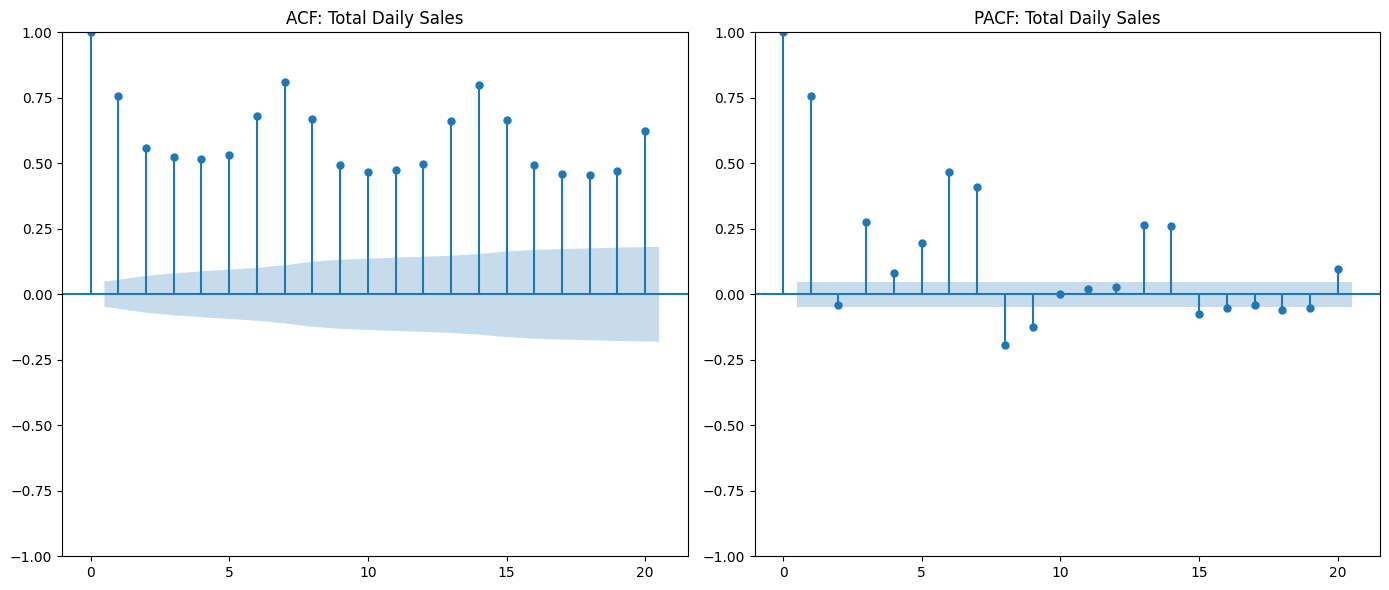

In [50]:
# Ensure date is datetime
train['date'] = pd.to_datetime(train['date'])

# 1. Group by date and compute total sales per day
daily_sales = train.groupby('date')['sales'].sum()

# 2. Plot ACF and PACF with lag 20
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(daily_sales, lags=20, ax=plt.gca())
plt.title("ACF: Total Daily Sales")

plt.subplot(1, 2, 2)
plot_pacf(daily_sales, lags=20, ax=plt.gca(), method='ywm')  # ywm for stable computation
plt.title("PACF: Total Daily Sales")

plt.tight_layout()
plt.show()


ACF Plot: The slow decay of autocorrelations across lags suggests the series is non-stationary with a strong trend or seasonality.

PACF Plot: A strong spike at lag 1 followed by smaller ones indicates the presence of autoregressive behavior, likely an AR(1) component.

### Q10. ADF Test -> ARIMA

#### Differencing technique
This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [38]:
# 1. Compute and store the diff series
train['date'] = pd.to_datetime(train['date'])
daily_sales = train.groupby('date')['sales'].sum()
sales_diff = daily_sales.diff()


# 2. Drop NA or any other erroneous values.

sales_diff = sales_diff.dropna()

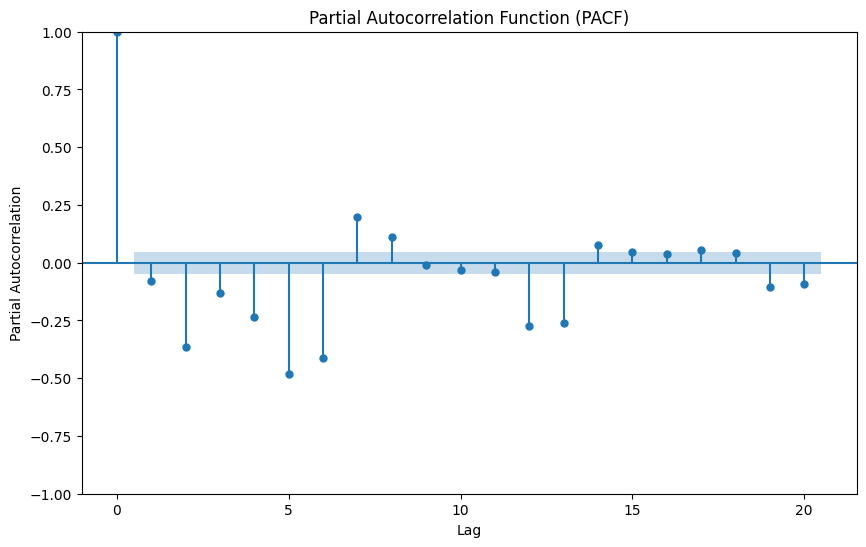

In [47]:


# Plot the ACF
fig, ax = plt.subplots(figsize=(10, 6))

##########
# TODO: Your plot code goes here:
plot_pacf(sales_diff, lags=20, ax=ax, method='ywm') 
##########

##########
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()



### Augmented Dickey-Fuller (ADF) test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [48]:
from statsmodels.tsa.stattools import adfuller

In [41]:
# 1. Perform the ADF test
adf_result = adfuller(sales_diff)

# 2. Extract the test statistics and p-value
adf_stat = adf_result[0]
p_value = adf_result[1]

# 3. Print the values
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

ADF Statistic: -11.553711234361751
p-value: 3.3987504192949185e-21


The ADF statistic is (around) -11.4. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-values (around)  i6.76e-2121, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

**TODO** Choose the right p, q and d values for your ARIMA model

In [42]:
# TODO: Replace with appropriate p,d,q values for ARIMA
p_arima = 1

d_arima = 1

q_arima = 1

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# 1. Get sales series as training data (np array with appropriate dtype)
sales_series = daily_sales.astype(float) 

# 2. Using statsmodel.tsa lib. Initialize an ARIMA model with the p,d,q params you defined. 
model = ARIMA(sales_series, order=(p_arima, d_arima, q_arima))

# 3. Fit the model
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [44]:
# Print the post model fitting summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1669
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22167.752
Date:                Fri, 25 Apr 2025   AIC                          44341.503
Time:                        02:44:30   BIC                          44357.762
Sample:                             0   HQIC                         44347.528
                               - 1669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4364      0.018     24.054      0.000       0.401       0.472
ma.L1         -0.9601      0.007   -131.833      0.000      -0.974      -0.946
sigma2      2.537e+10   1.28e-13   1.99e+23      0.0

In [49]:
# Make predictions & submit to competition using your best model

forecast_horizon = 15
forecast = model_fit.forecast(steps=forecast_horizon)

# 2. Create DataFrame of predictions
pred_df = pd.DataFrame({'sales': forecast})

# 3. Save as CSV (this is your submission)
#pred_df.to_csv("/kaggle/working/ARIMA_results.csv", index=False)
helper.make_submission(test_preds=pred_df['sales'], file_name="ARIMA_results.csv")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



## Section 3

### Q11 Define a validation set. What will be the most appropriate time period for this validation set?

In [55]:
# Get the val set:

# Assuming 'merged_df' has a datetime column named 'date'
train['date'] = pd.to_datetime(train['date'])

# Define the validation set to be the last two months before the test period
val_mask = (train['date'] >= '2017-06-01') & (train['date'] < '2017-08-01')
train_mask = ~val_mask

train_set = train[train_mask]
val_set = train[val_mask]

features = [col for col in train_set.columns if col not in ['id', 'date', 'sales']]

print(val_set)

                id       date  store_nbr        sales  onpromotion  cluster  \
2867502  2865456.0 2017-06-01        1.0     6.000000          0.0     13.0   
2867503  2865457.0 2017-06-01        1.0     0.000000          0.0     13.0   
2867504  2865458.0 2017-06-01        1.0     1.000000          0.0     13.0   
2867505  2865459.0 2017-06-01        1.0  2250.000000          9.0     13.0   
2867506  2865460.0 2017-06-01        1.0     3.000000          0.0     13.0   
...            ...        ...        ...          ...          ...      ...   
2976199  2974153.0 2017-07-31        9.0   470.513000          1.0      6.0   
2976200  2974154.0 2017-07-31        9.0    61.939999          0.0      6.0   
2976201  2974155.0 2017-07-31        9.0  1517.552002          6.0      6.0   
2976202  2974156.0 2017-07-31        9.0    56.000000          6.0      6.0   
2976203  2974157.0 2017-07-31        9.0    12.000000          0.0      6.0   

         events_Black_Friday  events_Cyber_Monday  

### Q12. LightGBM

In [79]:
#q12
import lightgbm as lgb
import numpy as np
from helper import make_submission

train_light_gbm = lgb.Dataset(train_set[features], label=train_set["sales"])
val_light_gbm = lgb.Dataset(val_set[features], label=val_set["sales"])

lgb_params = {
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'max_depth': 7,
    'verbose': 20,
    'num_boost_round': 1000,
    'early_stopping_rounds': 50,
    'nthread': -1
}

model = lgb.train(
    lgb_params,
    train_light_gbm,
    valid_sets=[train_light_gbm, val_light_gbm],
    callbacks=[lgb.early_stopping(stopping_rounds=lgb_params["early_stopping_rounds"])]
)

X_test = test.drop(columns=["id", "date"], errors="ignore")
test_preds = model.predict(X_test)

helper.make_submission(test_preds=test_preds, file_name="LGB_results.csv")

valid_predictions_gbm = model.predict(val_set[features])
rmsle_light_gbm = np.sqrt(mean_squared_log_error(val_set['sales'], np.maximum(valid_predictions_gbm, 0)))

print("Validation RMSLE (LGB):", rmsle_light_gbm)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.996016
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.933110
[LightGBM] [Debug] init for col-wise cost 0.908392 seconds, init for row-wise cost 1.316303 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.953215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 2867502, number of used features: 167
[LightGBM] [Info] Start training from score 352.037974
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree w

### Q13. CatBoost

In [74]:
from catboost import Pool, CatBoostRegressor

In [76]:
from sklearn.metrics import mean_squared_log_error

In [80]:
# -----------------------------------------
# 1. Define the model
# -----------------------------------------
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',     # Use RMSE for training
    'eval_metric': 'RMSE',       # MSLE is not reliable here; calculate RMSLE manually
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 100
}

cat_model = CatBoostRegressor(**catboost_params)

# -----------------------------------------
# 2. Fit (on log-transformed target)
# -----------------------------------------


cat_model.fit(
    train_set[features], train_set['sales'],
    eval_set=(val_set[features], val_set['sales']),
    use_best_model=True)

# -----------------------------------------
# 3. Preprocess test data if needed
# (assume already done if you're using same features)
# -----------------------------------------

# -----------------------------------------
# 4. Make Predictions (exponentiate to undo log1p)
# -----------------------------------------

X_test = test.drop(columns=["id", "date"], errors="ignore")
test_preds = cat_model.predict(X_test)

# -----------------------------------------
# 5. Submit
# -----------------------------------------
helper.make_submission(test_preds=test_preds, file_name="CatBoost_results.csv")

# -----------------------------------------
# 6. Note RMSLE for validation
# -----------------------------------------
valid_preds = model.predict(val_set[features])
rmsle = np.sqrt(mean_squared_log_error(val_set['sales'], np.maximum(valid_preds, 0)))

print("Validation RMSLE (CatBoost):", rmsle)

0:	learn: 1017.6827348	test: 1268.9895197	best: 1268.9895197 (0)	total: 209ms	remaining: 3m 29s
100:	learn: 498.8874281	test: 524.0766900	best: 524.0766900 (100)	total: 20.3s	remaining: 3m
200:	learn: 470.3200798	test: 492.5502775	best: 492.5502775 (200)	total: 39.3s	remaining: 2m 36s
300:	learn: 455.0710803	test: 477.4332716	best: 477.4332716 (300)	total: 58.9s	remaining: 2m 16s
400:	learn: 445.1519884	test: 466.6159097	best: 466.6159097 (400)	total: 1m 17s	remaining: 1m 55s
500:	learn: 438.2795416	test: 459.5538674	best: 459.5538674 (500)	total: 1m 37s	remaining: 1m 36s
600:	learn: 433.8571956	test: 455.9649781	best: 455.9649781 (600)	total: 1m 56s	remaining: 1m 17s
700:	learn: 430.7769576	test: 453.6247193	best: 453.6247193 (700)	total: 2m 15s	remaining: 57.6s
800:	learn: 428.1713121	test: 451.7684776	best: 451.7245441 (796)	total: 2m 34s	remaining: 38.3s
900:	learn: 425.9714751	test: 450.5529158	best: 450.5529158 (900)	total: 2m 52s	remaining: 19s
999:	learn: 424.2628472	test: 449.

### Q14. XGBoost

In [65]:
from xgboost import XGBRegressor

In [72]:
from xgboost import XGBRegressor
import numpy as np

# -----------------------------------------
# 1. Initialize model with random_state=42
# -----------------------------------------
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    early_stopping_rounds=50
)

# --------------------------------------------------
# Step 2: Train the model on log-transformed targets
# --------------------------------------------------
log_target_train = np.log1p(train_set["sales"])
log_target_val = np.log1p(val_set["sales"])

xgb_model.fit(
    train_set[features],
    log_target_train,
    eval_set=[(val_set[features], log_target_val)],
    verbose=100
)

# --------------------------------------------------
# Step 3: Generate predictions for the test set
# --------------------------------------------------
final_predictions = xgb_model.predict(test[features])
#final_predictions = np.expm1(log_predictions_test)

# --------------------------------------------------
# Step 4: Create submission file
# --------------------------------------------------
make_submission(final_predictions, "XGBoost_log_model.csv")

# --------------------------------------------------
# Step 5: Evaluate on validation set
# --------------------------------------------------
log_predictions_val = xgb_model.predict(val_set[features])
#val_predictions = np.expm1(log_predictions_val)

rmsle_cb = np.sqrt(np.mean((log_predictions_val - log_target_val) ** 2))
print(f"Validation RMSLE (Xgb): {rmsle_cb:.4f}")

[0]	validation_0-rmse:2.43934
[100]	validation_0-rmse:0.89738
[200]	validation_0-rmse:0.87789
[300]	validation_0-rmse:0.87523
[400]	validation_0-rmse:0.87338
[437]	validation_0-rmse:0.87339
Validation RMSLE (Xgb): 0.8732


## Optional Extra Credit Section - Achieve the lowest score

### Cross Validation Strategies & Ensembling

In [ ]:
# 1. Try different Validation sets 
# 2. Try ensembling different methods used in this assignment together